# ***This file compares Pauls best Model on my best model on Vienna data, to check for improvements***

In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
from scipy.io import loadmat
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

In [2]:
Paul = loadmat('PaulsPredictions_Vol6.mat')
Hauke = loadmat('HaukesPredictions_Vol6.mat')

In [3]:
PaulData = Paul['Data']
Spectra_Paul = np.fft.fftshift(np.fft.fft(PaulData, axis=-1), axes=-1)

HaukeData = Hauke['Data']
Spectra_Hauke = np.fft.fftshift(np.fft.fft(HaukeData, axis=-1), axes=-1)

In [4]:
Spectra_Paul.shape

(64, 64, 35, 840)

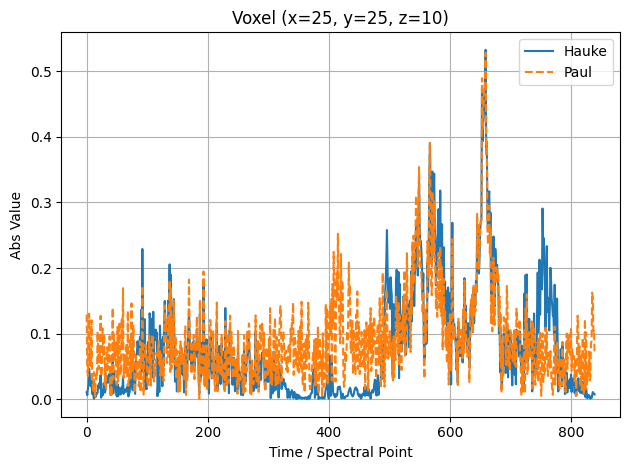

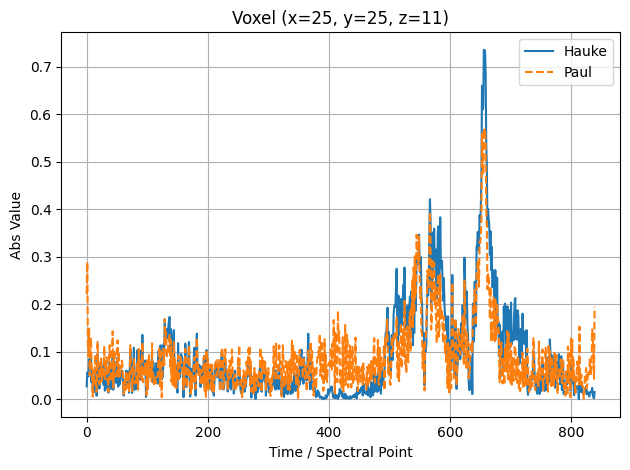

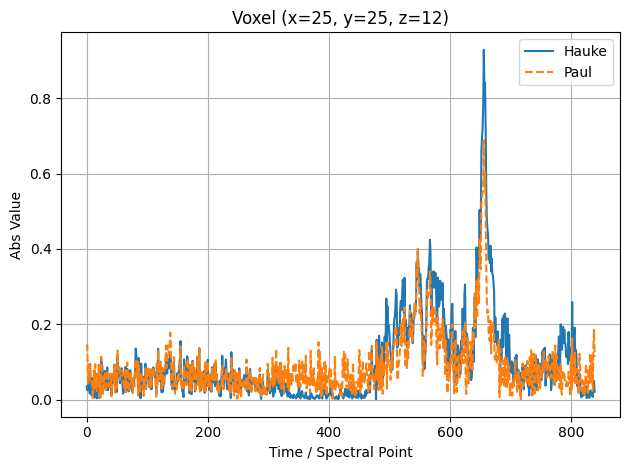

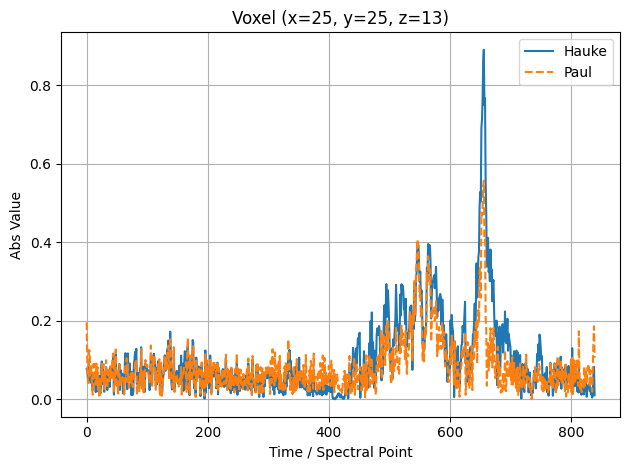

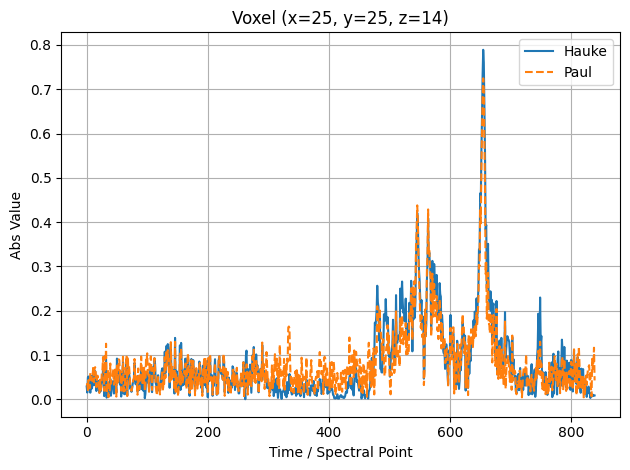

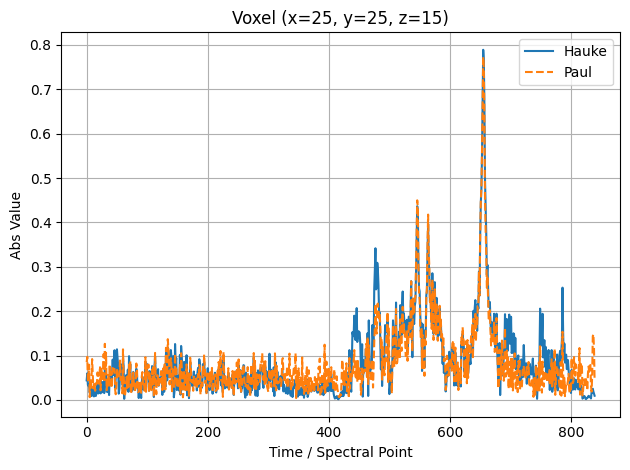

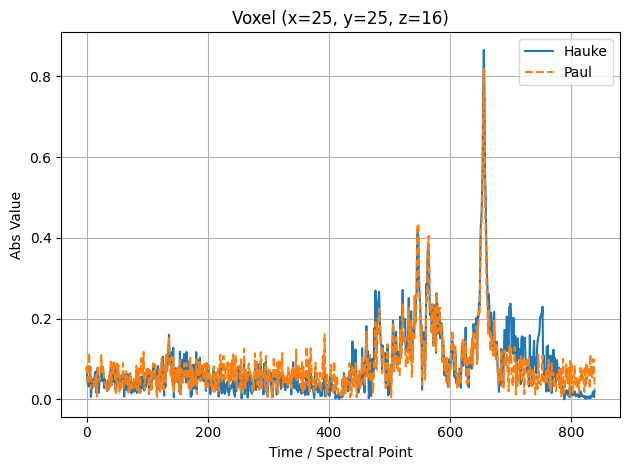

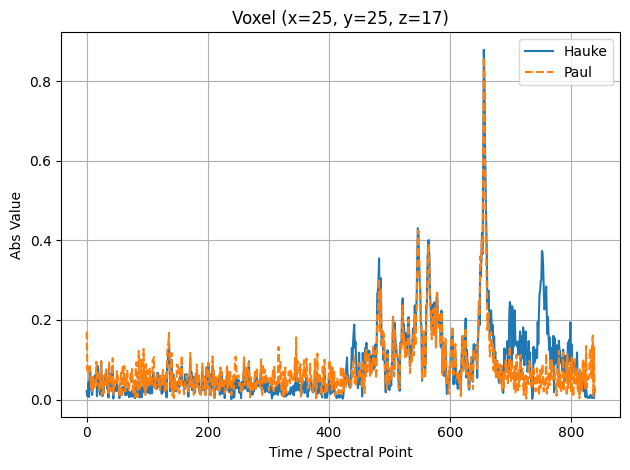

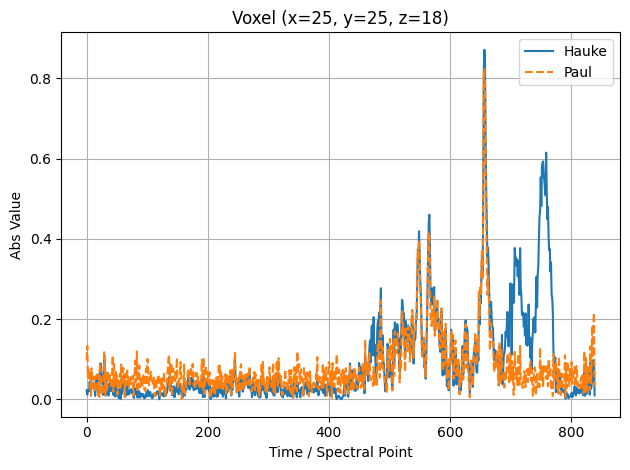

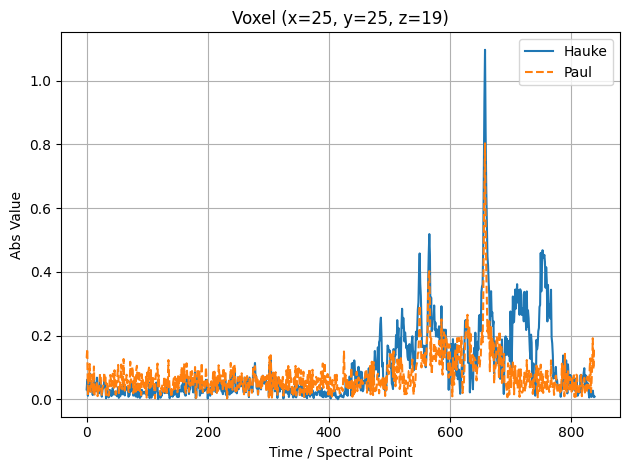

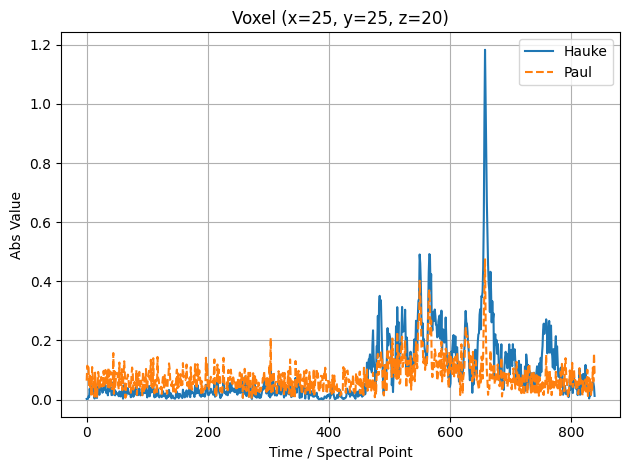

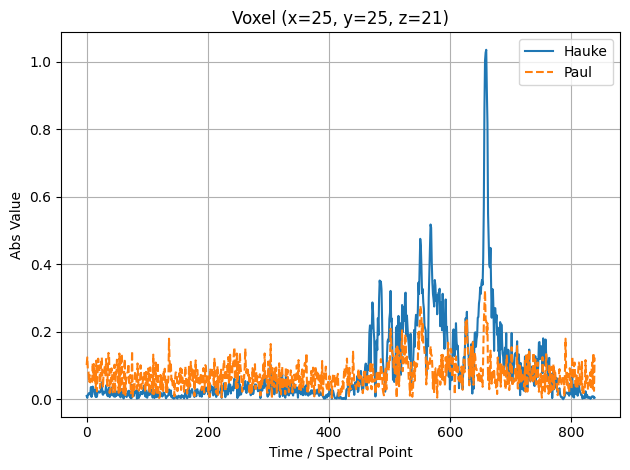

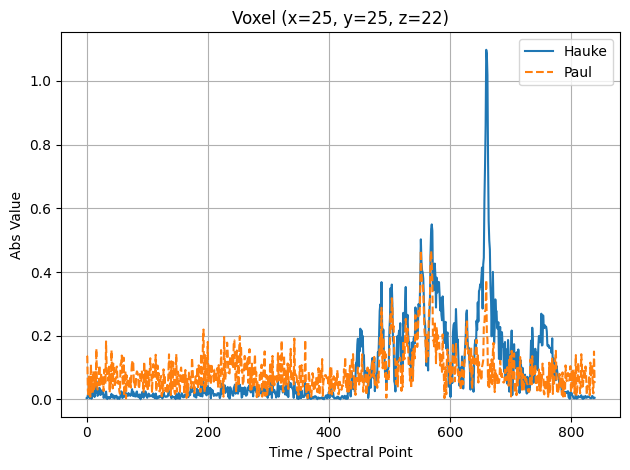

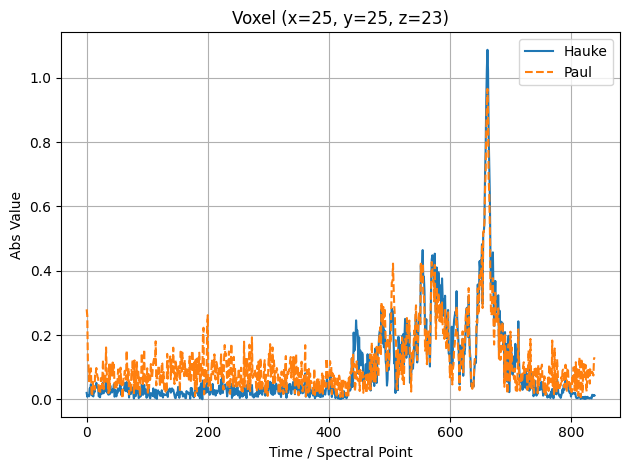

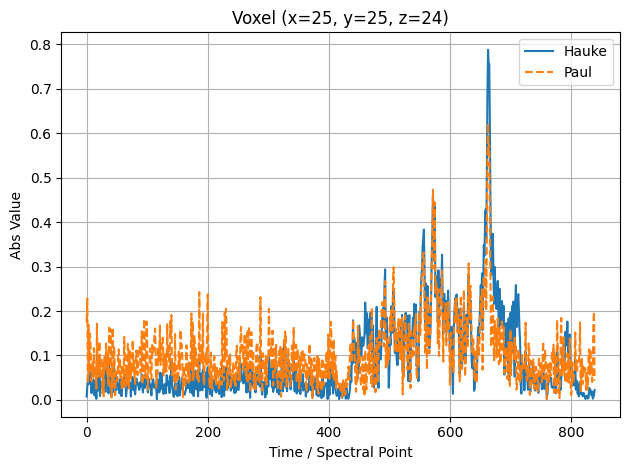

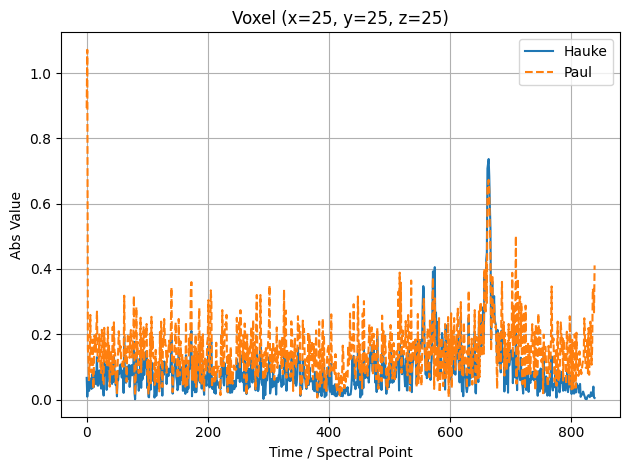

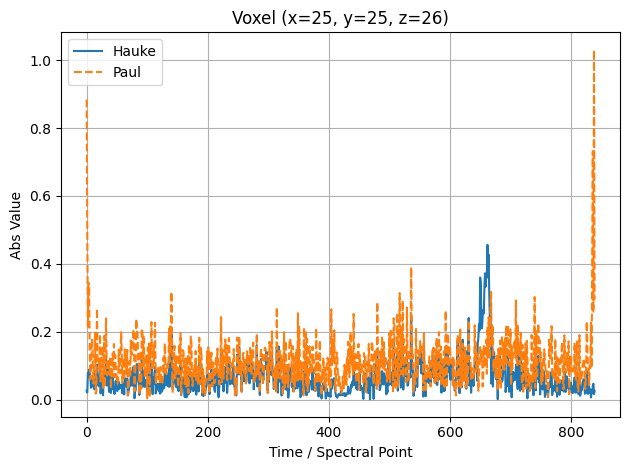

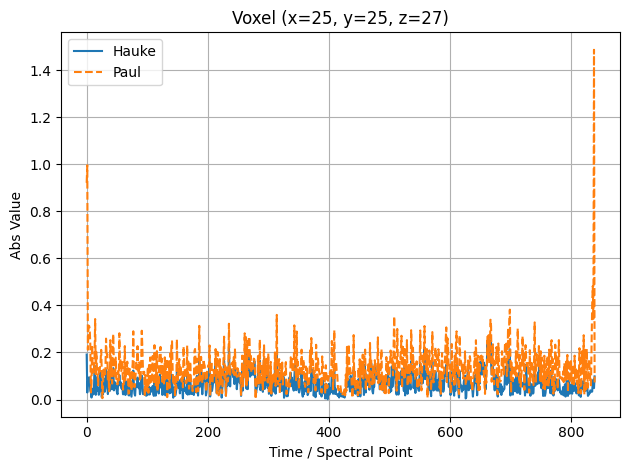

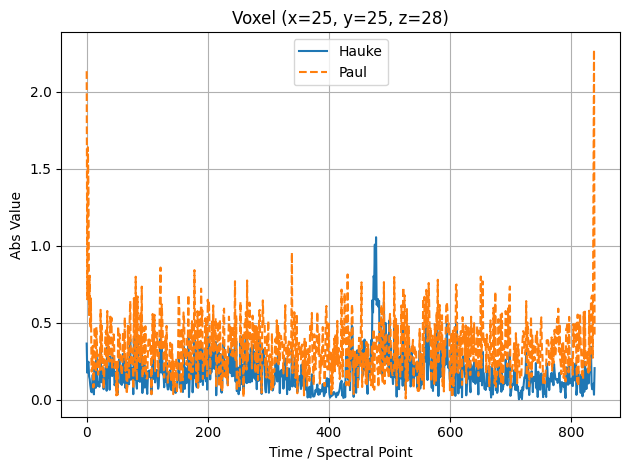

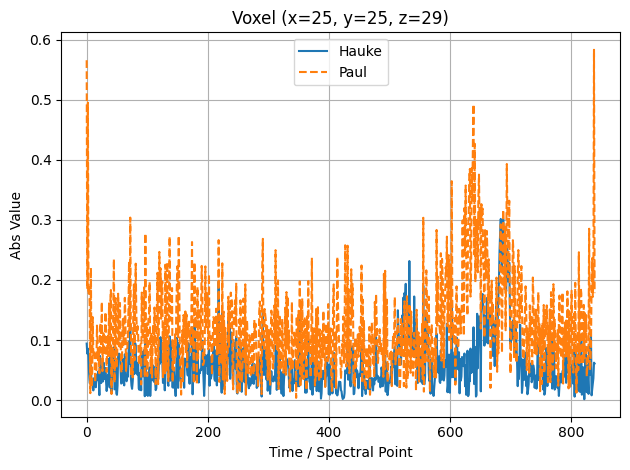

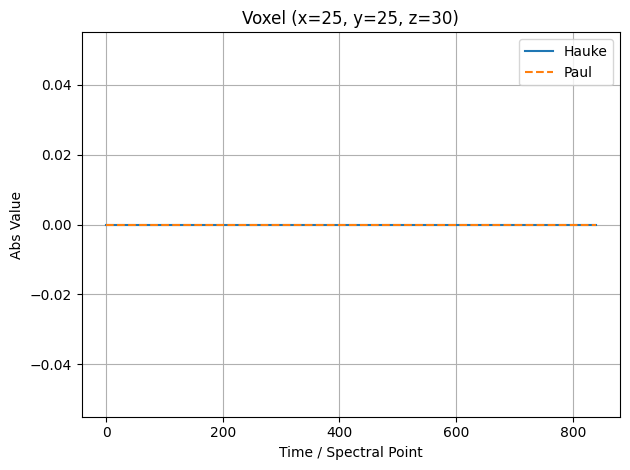

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed indices
x, y = 25, 25
z_range = range(10, 31)

for z in z_range:
    hauke_spectrum = np.abs(Spectra_Hauke[x, y, z, :])
    paul_spectrum = np.abs(Spectra_Paul[x, y, z, :])

    plt.figure()
    plt.plot(hauke_spectrum, label='Hauke')
    plt.plot(paul_spectrum, label='Paul', linestyle='dashed')
    plt.title(f'Voxel (x={x}, y={y}, z={z})')
    plt.xlabel('Time / Spectral Point')
    plt.ylabel('Abs Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
Spectra_Hauke.shape

(64, 64, 35, 840)